# 0. Imports

In [1]:
import sys

sys.path.append("../src/")

from utils import mean_std_cross_val_scores, plot_roc_curve

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import shuffle
from xgboost import XGBClassifier, XGBRegressor

from tqdm import tqdm

# 1. Data Preparation

In [2]:
df = pd.read_csv("../data/processed/labeled_data_CN7.csv", parse_dates=True)
df.set_index("TimeStamp", inplace=True)

In [3]:
df.head()

,Filling_Time,Max_Switch_Over_Pressure,_id,Hopper_Temperature,Cycle_Time,Max_Injection_Pressure,Plasticizing_Time,Average_Screw_RPM,Mold_Temperature_4,Reason,Max_Back_Pressure,Plasticizing_Position,Average_Back_Pressure,Max_Injection_Speed,PassOrFail,Injection_Time,Max_Screw_RPM,Mold_Temperature_3
TimeStamp,,,,,,,,,,,,,,,,,,
2020-10-16 04:57:47,4.47,136.800003,5f8928bb9c0189cc666ef19b,66.300003,59.520000,141.800003,16.92,292.5,27.5,None,37.400002,68.849998,59.299999,55.400002,0,9.59,30.700001,24.799999
2020-10-16 04:58:48,4.48,136.899994,5f8928de9c0189cc666ef20b,67.199997,59.580002,141.800003,16.91,292.5,27.6,None,37.500000,68.839996,59.299999,55.299999,0,9.60,30.799999,24.799999
2020-10-16 04:58:48,4.48,136.899994,5f8928df9c0189cc666ef213,67.199997,59.580002,141.800003,16.91,292.5,27.6,None,37.500000,68.839996,59.299999,55.299999,0,9.60,30.799999,24.799999
2020-10-16 04:59:48,4.48,136.800003,5f8928f39c0189cc666ef25e,66.900002,59.560001,141.800003,16.91,292.5,27.6,None,37.500000,68.839996,59.299999,55.299999,0,9.59,31.000000,25.000000
2020-10-16 04:59:48,4.48,136.800003,5f8928f59c0189cc666ef265,66.900002,59.560001,141.800003,16.91,292.5,27.6,None,37.500000,68.839996,59.299999,55.299999,0,9.59,31.000000,25.000000


In [4]:
numerical_features = [x for x in df.columns if np.dtype(df[x]) == "float64"]
target = ["PassOrFail"]
drop_features = set(list(df.columns)) - set(numerical_features) - set(target)

In [5]:
X = df[numerical_features]
y = df["PassOrFail"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y
)

# 2. Machine Learning

In [7]:
results = {}

## 2.1. Baseline Model

In [8]:
pipe_dummy = make_pipeline(StandardScaler(), DummyClassifier())

In [9]:
results["Dummy"] = mean_std_cross_val_scores(
    pipe_dummy, X_train, y_train, return_train_score=True, scoring="f1"
)

In [10]:
pd.DataFrame(results)

,Dummy
fit_time,0.004 (+/- 0.001)
score_time,0.002 (+/- 0.001)
test_score,0.000 (+/- 0.000)
train_score,0.000 (+/- 0.000)


## 2.2. ML Models

#### 2.2.1. Cross-Validation

In [11]:
pipe_dt = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=123))
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(random_state=123))
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=123, probability=True))
pipe_rf = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(StandardScaler(), XGBClassifier(random_state=123, verbosity=0))
pipe_lgbm = make_pipeline(StandardScaler(), LGBMClassifier(random_state=123))
pipe_catb = make_pipeline(
    StandardScaler(), CatBoostClassifier(random_state=123, verbose=0)
)

In [12]:
models = {
    "decision_tree": pipe_dt,
    "logistic_regression": pipe_lr,
    "SVC": pipe_svc,
    "random_forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catb,
}

In [13]:
for name, model in tqdm(models.items()):
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring="f1"
    )

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:16<00:00,  2.33s/it]


In [14]:
pd.DataFrame(results)

,Dummy,decision_tree,logistic_regression,SVC,random_forest,XGBoost,LightGBM,CatBoost
fit_time,0.004 (+/- 0.001),0.008 (+/- 0.000),0.016 (+/- 0.003),0.060 (+/- 0.015),0.171 (+/- 0.005),0.326 (+/- 0.520),0.097 (+/- 0.015),2.466 (+/- 0.408)
score_time,0.002 (+/- 0.001),0.002 (+/- 0.000),0.003 (+/- 0.001),0.007 (+/- 0.002),0.012 (+/- 0.001),0.009 (+/- 0.001),0.007 (+/- 0.000),0.004 (+/- 0.001)
test_score,0.000 (+/- 0.000),0.448 (+/- 0.219),0.461 (+/- 0.280),0.598 (+/- 0.197),0.496 (+/- 0.260),0.463 (+/- 0.193),0.496 (+/- 0.260),0.496 (+/- 0.260)
train_score,0.000 (+/- 0.000),0.839 (+/- 0.049),0.629 (+/- 0.079),0.665 (+/- 0.056),0.857 (+/- 0.035),0.842 (+/- 0.043),0.841 (+/- 0.050),0.839 (+/- 0.049)


#### 2.2.2. Confusion Matrix & Classification Report

In [15]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Confusion Matrix for {name}")
    print(confusion_matrix(y_test, y_pred))
    print("\n")
    print(f"Classification Report for {name}")
    print(classification_report(y_test, y_pred))
    print("-----------------------------------------------------")

Confusion Matrix for decision_tree
[[1183    2]
 [   3    5]]


Classification Report for decision_tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1185
           1       0.71      0.62      0.67         8

    accuracy                           1.00      1193
   macro avg       0.86      0.81      0.83      1193
weighted avg       1.00      1.00      1.00      1193

-----------------------------------------------------
Confusion Matrix for logistic_regression
[[1185    0]
 [   4    4]]


Classification Report for logistic_regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1185
           1       1.00      0.50      0.67         8

    accuracy                           1.00      1193
   macro avg       1.00      0.75      0.83      1193
weighted avg       1.00      1.00      1.00      1193

-----------------------------------------------------
Confusion Matrix f

#### 2.2.3. ROC Curve

ROC Curve for decision_tree


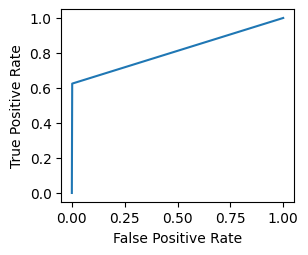

f1 score of decision_tree : 0.67
-----------------------------------------------------
ROC Curve for logistic_regression


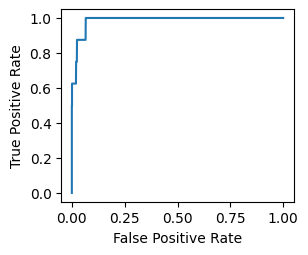

f1 score of logistic_regression : 0.67
-----------------------------------------------------
ROC Curve for SVC


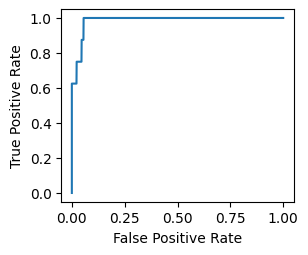

f1 score of SVC : 0.67
-----------------------------------------------------
ROC Curve for random_forest


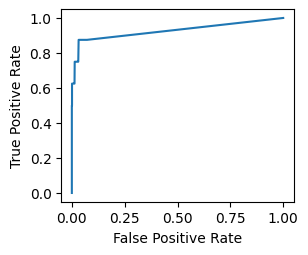

f1 score of random_forest : 0.67
-----------------------------------------------------
ROC Curve for XGBoost


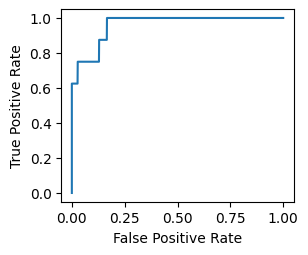

f1 score of XGBoost : 0.67
-----------------------------------------------------
ROC Curve for LightGBM


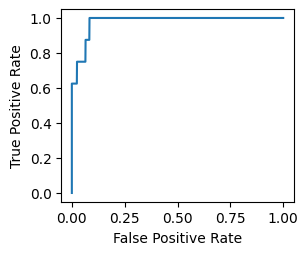

f1 score of LightGBM : 0.67
-----------------------------------------------------
ROC Curve for CatBoost


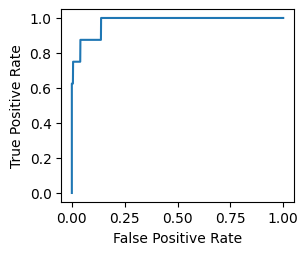

f1 score of CatBoost : 0.71
-----------------------------------------------------


In [16]:
for name, model in models.items():
    print(f"ROC Curve for {name}")
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    plot_roc_curve(y_test, y_prob[:, 1])
    f1 = f1_score(y_test, y_pred)
    print(f"f1 score of {name} : {np.round(f1, 2)}")
    print("-----------------------------------------------------")

# 3. Test Summary

- `SVC` showed the highest test score in the cross-validation.
- When the machine learning models were fitted on the train set, and evaluated on the test set, `CatBoost` showed the highest f1 score of 0.71.